# Capstone project by Sebastien Peytrignet

# Trash or Treasure? Using machine learning to classify and segment images of litter

# Notebook 1: The problem and exploratory data analysis

## 1) The problem

Among household waste materials, plastic and glass bottles are among the easiest objects to recycle and, in Switzerland, 82% of PET plastic bottles and 94% of glass bottles are currently [recycled](https://www.swissinfo.ch/eng/society/recycling_plastic-bottle-recycling-gets-easier-in-switzerland-/45477432
). In some countries, such as Germany, plastic and glass bottles can even be traded for cash at exchage points - thus making them the 'treasure' in our project title.

If we were able to find the remaining bottles, could we bring this rate closer to 100%? In this project, we will propose machine learning models to process images of litter, which might help with recycling efforts. We will carry out two **classification** analyses (C) and one image **segmentation** analysis (S), described below.

* **Analysis C.1:** Based on images of litter, can we identify which images include bottles?

  We will consider images of the following objects:

  * Bottles
  * Cartons
  * Cups
  * Cans
  * Plastic film

* **Analysis C.2:** Among images of bottles, can we classify their material?

  We will consider the following materials:

  * Glass
  * Plastic

* **Analysis S.1:** In images containing bottles, can we locate the bottle itself within the image?

![recycling](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Glass_and_plastic_recycling_065_ubt.JPG/640px-Glass_and_plastic_recycling_065_ubt.JPG)

*Creative Commons Attribution 3.0 © 2008 by Tomasz Sienicki*

## 2) The data

![taco-logo](http://tacodataset.org/img/logonav.png)

*Trash Annotations in Context, by Pedro Proença and Pedro Simões*

We will work with data from the [TACO project](http://tacodataset.org/) (Trash Annotations in Context). The images in this project are crowd-sourced, with users manually uploading their images and providing the labels and object masks themselves through an online portal. Submitted images are periodically reviewed, and then added to the dataset in GitHub.

According to its creators, images in the dataset are in contexts ranging *'from tropical beaches to London streets'*. We will describe the dataset in more detail below, but background information on the project can be found on the [TACO website](http://tacodataset.org/) or in the TACO project [GitHub repository](https://github.com/pedropro/TACO).

The project creators have also authored an [academic paper](https://arxiv.org/pdf/2003.06975.pdf) with more information on the potential uses of the data. Although this dataset has already been used for classification and segmentation by other data scientists, our focus on bottles and our data processing approach make this analysis unique.

### Read in data

Explain which files are included - in less detail than in the proposal.

In [1]:
%matplotlib inline
import os
import json
import numpy as np
import pandas as pd

In [2]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
from random import sample

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Dataset path - where the raw data is stored
dataset_path = '/content/drive/MyDrive/TACO'

In [6]:
# Features path - where we will save our clean images
features_path = '/content/drive/MyDrive/TACO features'

We load in an extract of the TACO data which is composed of:
* 1,500 raw images, stored in 15 sub-folders labelled "batch 1" to "batch 15".
* A json file called "annotations.json", organised in the convenient [COCO-Json](https://haobin-tan.netlify.app/ai/computer-vision/object-detection/coco-dataset-format/) format, widely used for object detection datasets.

In [7]:
# Read annotations file
with open("{}/annotations.json".format(dataset_path), 'r') as f:
    annotdata = json.loads(f.read())

### Show sample of images

Next, we will visualize a random sample of the images and annotations. To visualize this, we have adapted a function provided by Dr. Sreenivas Bhattiprolu that works on images annotated in the COCO-Json format ([link to GitHub](https://github.com/bnsreenu/python_for_microscopists/blob/master/335%20-%20Converting%20COCO%20JSON%20annotations%20to%20labeled%20mask%20images/335c-visualize-COCO%20labels.py
)).

In [8]:
import matplotlib.patches as patches

In [9]:
def display_images_with_coco_annotations(image_id_subset, figtitle, dataset_path, annotations, display_type='both', colors=None):
    """
    Function to display images with COCO annotations. Adapted from Dr. Sreenivas Bhattiprolu.

    Parameters:
    - image_id_subset (list): A list of image IDs to display.
    - figtitle (str): Title for the figure.
    - dataset_path (str): Path to the dataset directory.
    - annotations (dict): The dictionary containing COCO annotations data.
    - display_type (str, optional): Type of annotations to display. Options are 'bbox', 'seg', or 'both'. Default is 'both'.
    - colors (list, optional): List of colors for displaying annotations. Default is None.

    Returns:
    - None
    """
    # Subset of images that include the specified type
    subset_files = [os.path.join(dataset_path, img['file_name']) for img in annotations['images'] if img["id"] in image_id_subset]

    # Random subset of 6 images
    random.seed(0)
    image_paths = random.sample(subset_files, min(6,len(image_id_subset)))

    fig, axs = plt.subplots(2, 3, figsize=(6, 4))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Define a default color map if none is provided
        if colors is None:
            colors = plt.colormaps["tab10"]

        # Get image filename to match with annotations
        path_components = img_path.split("/")
        short_path = "{}/{}".format(path_components[-2],path_components[-1])
        img_id = next(item["id"] for item in annotations['images'] if item["file_name"] == short_path)

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        for ann in img_annotations:
            category_id = ann['category_id']
            color = colors(category_id % 10)

            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color, fill=False)
                    ax.add_patch(polygon)

    plt.tight_layout(rect=[0, 0, 0.98, 0.98])
    fig.suptitle(figtitle)
    plt.show()

In [10]:
random_images = pd.Series([line["id"] for line in annotdata["images"]]).sample(6, random_state=1)

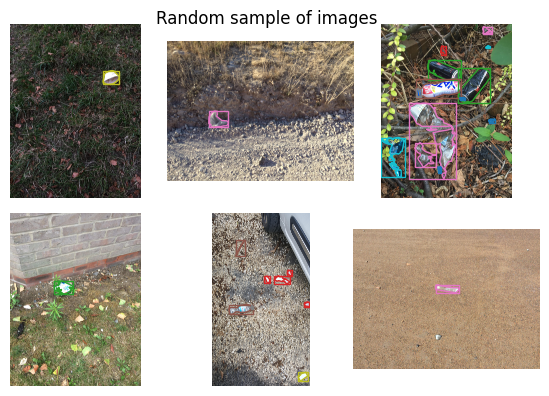

In [11]:
display_images_with_coco_annotations(image_id_subset=random_images, figtitle="Random sample of images", dataset_path=dataset_path, annotations=annotdata, display_type='both')

From our snapshot of the data above, we can see that the images will need some processing before we can apply our models:

* Often, the object is very small in relation to the image background. This is particularly the case for small objects, like cigarette butts.
* Some objects appear 'distorted' - for example, they are bent or broken. This appears to be more common among objects photographed outdoors and those made of soft materials (like plastic film or cardboard). These distortions might make the images more difficult to classify.
* Object masks (the segmentations) are not provided as stand-alone images, so we will need to create them for each annotation.

## 3) Exploratory data analysis

### Missing data and duplicates

#### Image dataset

First, we conduct some exploratory data analysis (EDA) at the image level. We start by saving the images data into a pandas DataFrame.

The images file contains one row per image in the dataset, for a total of 1,500 images. It contains:

* An image id
* Image width
* Image height
* File name (and its batch)
* Type of license

All information on the date captured is missing.

Looking at the image license information, it appears that images are either a creative common or they have been provided by [OpenLitterMap](https://github.com/OpenLitterMap/openlittermap-web), another open source project.

There are no duplicates in the images dataset.

In [12]:
pd.DataFrame(annotdata["images"]).shape

(1500, 9)

In [13]:
pd.DataFrame(annotdata["images"]).head()

,id,width,height,file_name,license,flickr_url,coco_url,date_captured,flickr_640_url
0,0,1537,2049,batch_1/000006.jpg,None,https://farm66.staticflickr.com/65535/33978196...,None,None,https://farm66.staticflickr.com/65535/33978196...
1,1,1537,2049,batch_1/000008.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
2,2,1537,2049,batch_1/000010.jpg,None,https://farm66.staticflickr.com/65535/40888872...,None,None,https://farm66.staticflickr.com/65535/40888872...
3,3,2049,1537,batch_1/000019.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
4,4,1537,2049,batch_1/000026.jpg,None,https://farm66.staticflickr.com/65535/33978199...,None,None,https://farm66.staticflickr.com/65535/33978199...


<Axes: >

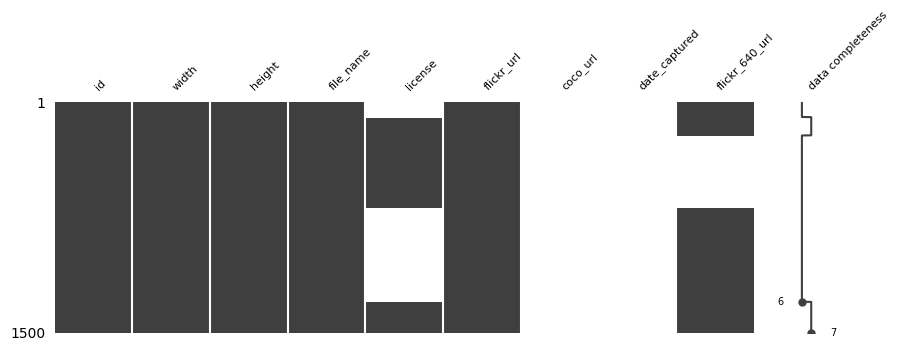

In [14]:
import missingno as msno
msno.matrix(pd.DataFrame(annotdata["images"]), fontsize=8,labels=True, figsize=(10,3))

In [15]:
sum(pd.DataFrame(annotdata["images"]).duplicated(subset=['id']))

0

#### Annotations dataset

The annotations file is where we will find most of the relevant information for our analysis. This is where each annotation (e.g. the contour of a plastic bottle and the 'plastic bottle' tag) is stored.

There are 4,784 annotations in this version of the dataset.

This dataset includes:

* The annotation id (id)
* Its corresponding image id (image_id)
* The category id (category_id), i.e. whether the annotation is a bottle, a pizza box or other.
* The segmentation itself ('segmentation'), with values indicating which pixels are within the segment (also called the 'mask').
* The annotation area ('area').
* The bounding box for the annotation ('bbox'), i.e. the rectangular area containing the edges of the annotation. This is a list of four numbers representing the bounding box of the annotated object in the format [x, y, width, height], where (x, y) is the top-left corner of the bounding box ([source](https://medium.com/@manuktiwary/coco-format-what-and-how-5c7d22cf5301)).
* Whether the annotation is part of a group of annotations (e.g. broken pieces of a glass bottle) in 'is crowd'.

In [16]:
pd.DataFrame(annotdata["annotations"]).shape

(4784, 7)

In [17]:
pd.DataFrame(annotdata["annotations"]).head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1071259.5,"[1.0, 457.0, 1429.0, 1519.0]",0
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",99583.5,"[531.0, 292.0, 1006.0, 672.0]",0
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",915.0,"[632.0, 989.0, 44.0, 51.0]",0


It appears that none of the annotations here are part of a 'crowd'.

In [18]:
pd.DataFrame(annotdata["annotations"])["iscrowd"].value_counts()

0    4784
Name: iscrowd, dtype: int64

There are no missing values.

<Axes: >

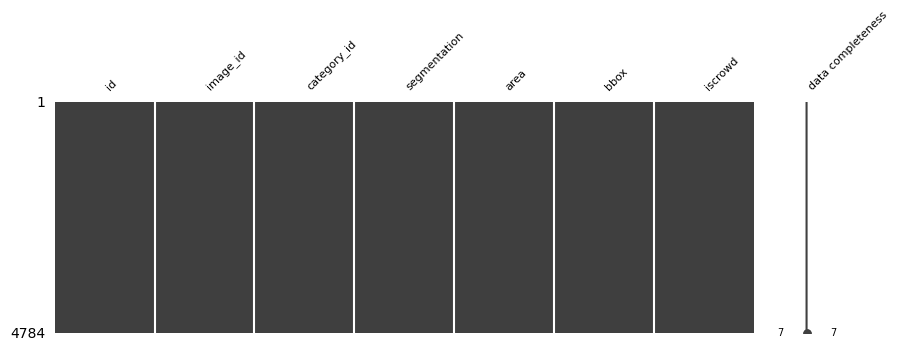

In [19]:
msno.matrix(pd.DataFrame(annotdata["annotations"]), fontsize=8,labels=True, figsize=(10,3))

One annotation appears twice. We will drop this later.

In [20]:
sum(pd.DataFrame(annotdata["annotations"]).duplicated(subset=['id']))

2

### Image size in pixels and height/width ratio

First, we conduct some exploratory EDA at the image level. We start by saving the images data into a pandas DataFrame.

In [21]:
rawimage_df = pd.DataFrame(annotdata["images"])

We create an 'area' variable for the image size, and visualize the first five rows of the data.

In [22]:
rawimage_df["area"] = rawimage_df["width"]*rawimage_df["height"]

In [23]:
rawimage_df.head()

,id,width,height,file_name,license,flickr_url,coco_url,date_captured,flickr_640_url,area
0,0,1537,2049,batch_1/000006.jpg,None,https://farm66.staticflickr.com/65535/33978196...,None,None,https://farm66.staticflickr.com/65535/33978196...,3149313
1,1,1537,2049,batch_1/000008.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...,3149313
2,2,1537,2049,batch_1/000010.jpg,None,https://farm66.staticflickr.com/65535/40888872...,None,None,https://farm66.staticflickr.com/65535/40888872...,3149313
3,3,2049,1537,batch_1/000019.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...,3149313
4,4,1537,2049,batch_1/000026.jpg,None,https://farm66.staticflickr.com/65535/33978199...,None,None,https://farm66.staticflickr.com/65535/33978199...,3149313


The median image size has approximately 8 million pixels.

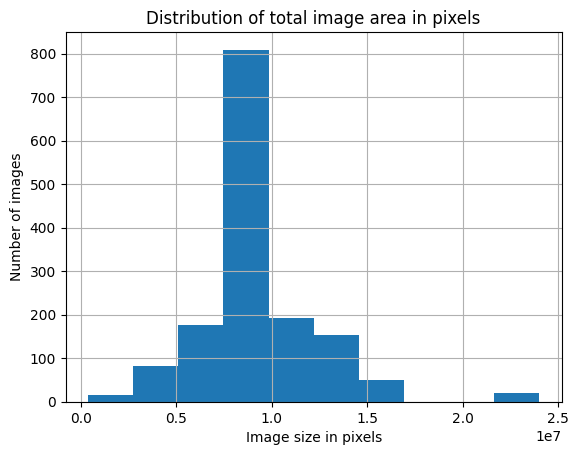

In [24]:
rawimage_df["area"].hist()
plt.title("Distribution of total image area in pixels")
plt.xlabel("Image size in pixels")
plt.ylabel("Number of images")
plt.show()

We also summarise the height/width ratio of all images. Half of images have a ratio of 1.3, and 25% have a ratio of 0.75. If we rotate the images that have a 0.75 ratio 90 degrees to the left or right, then 75% of images will have exactly the same format (since the inverse of 1.3 is 0.75).

In [25]:
(rawimage_df.height/rawimage_df.width).value_counts(normalize=True).nlargest(n=10)

1.333333    0.518000
0.750000    0.256667
2.192982    0.070000
1.777778    0.050000
0.456000    0.030667
1.333116    0.023333
0.666667    0.013333
0.750122    0.008000
1.777027    0.006000
0.562738    0.003333
dtype: float64

### Most common annotations: by supercategory

Now, we conduct some exploratory EDA at the annotation level. We start by saving the annotations data into a pandas DataFrame.

In [26]:
annot_df = pd.DataFrame(annotdata["annotations"]).drop(["area"], axis=1)

We drop the duplicated annotation (which is tagged with two different categories).

In [27]:
annot_df.drop_duplicates(subset=['id'], keep='first', inplace=True)

Then, we merge in the annotation category labels so that we can conveniently see to which category and supercategory each annotation belongs.

In [28]:
categories_dict = pd.DataFrame(annotdata["categories"]).loc[:,["id","name","supercategory"]]
categories_dict.rename({'id': 'category_id', 'name': 'category'}, axis=1, inplace=True)
annot_df = annot_df.merge(categories_dict, on='category_id', how='left').copy()

In [29]:
annot_df.head()

,id,image_id,category_id,segmentation,bbox,iscrowd,category,supercategory
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...","[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle,Bottle
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...","[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton,Carton
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...","[531.0, 292.0, 1006.0, 672.0]",0,Other carton,Carton
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...","[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle,Bottle
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...","[632.0, 989.0, 44.0, 51.0]",0,Plastic bottle cap,Bottle cap


We would like to visualize the most common supercategories. Please note that, because of the large number of supercategories, some colours in the palette are used twice.

The most common supercategory is "plastic bag and wrapper", which contains many different types of objects such as plastic film, carrier bags and crisp packets. The second most common supercategory are cigarettes, followed by 'unlabelled litter'. Some supercategories, like shoes or batteries, are very rare.

In [30]:
supercat_palette = pd.DataFrame(dict({'supercategory': annot_df["supercategory"].value_counts().index,
      'color': sns.color_palette("Dark2",28).as_hex()}))

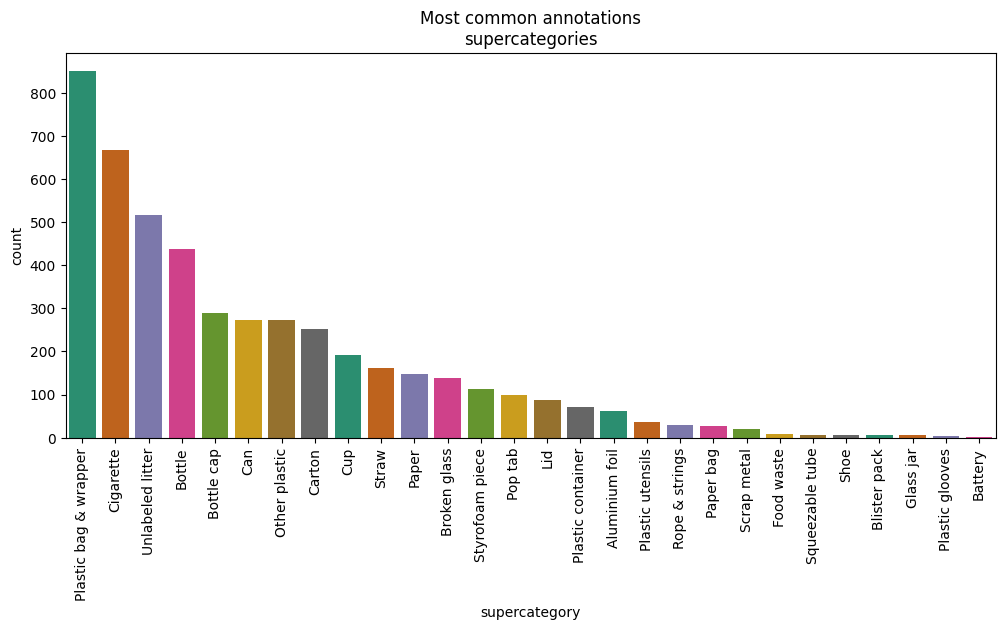

In [36]:
plt.figure(figsize=(12,5))
sns.countplot(annot_df, orient="v", x="supercategory", order=annot_df["supercategory"].value_counts().index, palette=supercat_palette.color)
plt.xticks(rotation = 90)
plt.title("Most common annotations\nsupercategories")
plt.show()

In [37]:
# plt.figure(figsize=(5,10))
# sns.countplot(annot_df, orient="v", y="supercategory", order=annot_df["supercategory"].value_counts().index, palette=supercat_palette.color)
# plt.title("Most common annotations\nsupercategories")
# plt.show()

### Most common annotations: by category

Next, we visualize the most frequent annotations by category. We colour-code the categories by supercategories, and retain the same supercategory color scheme used above.

Cigarettes are the most common annotation. We suspect that this might be due to images containing multiple cigarettes next to each other.

Focussing on bottle annotations, we can see that plastic bottles appear at a rate of approximately 3-to-1 compared to glass bottles.


In [38]:
counts_by_cat = pd.DataFrame(annot_df.groupby(["supercategory","category"]).size(),columns=["count"]).reset_index()
counts_by_cat["supercount"] = counts_by_cat.groupby("supercategory")["count"].transform('sum')
counts_by_cat = counts_by_cat.sort_values(by=['supercount','count'], ascending=False)
counts_by_cat = counts_by_cat.merge(supercat_palette,how="left",on="supercategory")

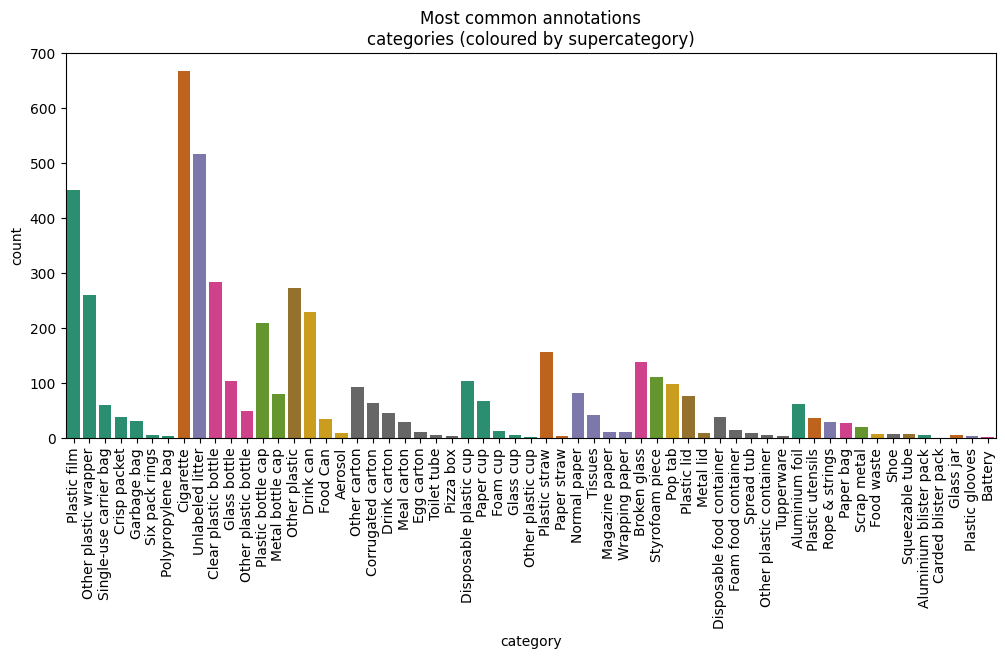

In [39]:
plt.figure(figsize=(12,5))
sns.countplot(annot_df, x="category", orient="v", palette=counts_by_cat.color, order=counts_by_cat.category)
plt.xticks(rotation = 90)
plt.title("Most common annotations\ncategories (coloured by supercategory)")
plt.show()

In [40]:
# plt.figure(figsize=(5,12))
# sns.countplot(annot_df, y="category", orient="v", palette=counts_by_cat.color, order=counts_by_cat.category)
# plt.xticks(rotation = 90)
# plt.title("Most common annotations\ncategories (coloured by supercategory)")
# plt.show()

### Association rules

Next, we are interested in finding out which objects tend to appear in the same image.

For this purpose, we apply association rules analysis using the [APRIORI algorithm](https://en.wikipedia.org/wiki/Apriori_algorithm). This methodology is commonly used in marketing, for example, to investigate which combinations of products customers tend to buy during the same shopping trip.

This algorithm can be used in our setting to point to the combinations of objects that tend to appear in the same image.

In [ ]:
arules_data = pd.crosstab(annot_df.loc[:,"image_id"],
                          annot_df.loc[:,"supercategory"])
arules_data[arules_data>1] = 1

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
combinations = apriori(arules_data, min_support = 0.001, use_colnames = True, verbose = 1)
rules = association_rules(combinations)

Processing 8 combinations | Sampling itemset size 8


We can extract three statistics for each 'association rule', but we will focus on support and confidence.

An association rule could be, for example, 'Carton → Bottle'. If this rule's support was 0.2, this would mean that 20% of all images had at least one carton and at least one bottle. If the confidence was 0.1, it would mean that 10% of images containing at least one carton also included at least one bottle.

![Association rules](https://i.postimg.cc/x1grnHxx/Formulae-for-support-confidence-and-lift-for-the-association-rule-X-Y.png)

*Yaman, Sezin & Fagerholm, Fabian & Munezero, Myriam & Männistö, Tomi & Mikkonen, Tommi. (2019). Patterns of User Involvement in Experiment-Driven Software Development. Information and Software Technology. 120. 106244. 10.1016/j.infsof.2019.106244.*

We show the association rules below, ranked in terms of their support. We can see that the most common combination are cans and pop tabs (i.e. the detachable lid of the can). 83% of images containing a pop tab also contain the can itself.

In [ ]:
rules.sort_values(["support"],axis = 0, ascending = False, inplace=True)
rules.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Pop tab),(Can),0.047365,0.119413,0.039360,0.830986,6.958927,0.033704,5.210140,0.898875
6,"(Bottle cap, Plastic bag & wrapper)",(Bottle),0.028019,0.214143,0.024016,0.857143,4.002670,0.018016,5.501001,0.771791
129,"(Other plastic, Bottle, Unlabeled litter)",(Plastic bag & wrapper),0.009340,0.348232,0.008005,0.857143,2.461412,0.004753,4.562375,0.599327
57,"(Bottle cap, Plastic bag & wrapper, Carton)",(Bottle),0.006671,0.214143,0.006004,0.900000,4.202804,0.004575,7.858572,0.767182
79,"(Other plastic, Bottle cap, Plastic bag & wrap...",(Bottle),0.006671,0.214143,0.006004,0.900000,4.202804,0.004575,7.858572,0.767182


Since this analysis has a special focus on bottles, we can investigate which items tend to appear in the same pictures as bottles.

We can see that if an image contains a bottle cap and plastic bag/wrapper, there is an 86% likelihood that it also includes a bottle.

In [ ]:
#Find which rows have "Bottles" in the antecedents, but not counting instances of "Bottle cap"
antecedents_clean = rules["antecedents"].astype(str).str.replace('Bottle cap', '', regex=True)
antecedents_clean_idx = antecedents_clean.str.contains('Bottle', case=False, regex=True)

#Find which rows have "Bottles" in the consequents, but not counting instances of "Bottle cap"
consequents_clean = rules["consequents"].astype(str).str.replace('Bottle cap', '', regex=True)
consequents_clean_idx = consequents_clean.str.contains('Bottle', case=False, regex=True)

In [ ]:
rules.loc[antecedents_clean_idx|consequents_clean_idx,:].head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
6,"(Bottle cap, Plastic bag & wrapper)",(Bottle),0.028019,0.214143,0.024016,0.857143,4.002670,0.018016,5.501001,0.771791
129,"(Other plastic, Bottle, Unlabeled litter)",(Plastic bag & wrapper),0.009340,0.348232,0.008005,0.857143,2.461412,0.004753,4.562375,0.599327
57,"(Bottle cap, Plastic bag & wrapper, Carton)",(Bottle),0.006671,0.214143,0.006004,0.900000,4.202804,0.004575,7.858572,0.767182
79,"(Other plastic, Bottle cap, Plastic bag & wrap...",(Bottle),0.006671,0.214143,0.006004,0.900000,4.202804,0.004575,7.858572,0.767182
78,"(Other plastic, Bottle cap, Bottle)",(Plastic bag & wrapper),0.006004,0.348232,0.006004,1.000000,2.871648,0.003913,inf,0.655705


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Create class labels for classification problems

Our first classification task will try to distinguish between five types of objects:
* Bottles
* Cartons
* Cups
* Cans
* Plastic film

We create the string variable 'c1_label' containing the object labels according to the above taxonomy, and its numerical version 'c1_numlabel'.

In [41]:
#Create the c1 "label" variable
annot_df["c1_label"] = np.nan
annot_df.loc[annot_df["supercategory"]=="Bottle","c1_label"] = "Bottle"
annot_df.loc[annot_df["supercategory"]=="Carton","c1_label"] = "Carton"
annot_df.loc[annot_df["supercategory"]=="Cup","c1_label"] = "Cup"
annot_df.loc[annot_df["category"].isin(["Drink can","Food can"]),"c1_label"] = "Can"
annot_df.loc[annot_df["category"].isin(["Plastic film"]),"c1_label"] = "Plastic film"

#Create the numerical "label" variable
annot_df["c1_numlabel"] = annot_df['c1_label'].replace(list(annot_df['c1_label'].value_counts().index),list(range(1,6)), inplace=False)

Our second classification task will try to distinguish between bottles made of two materials:
* Glass
* Plastic

We create the string variable 'c2_label' containing the object labels according to the above taxonomy, and its numerical version 'c2_numlabel'.

In [42]:
#Create the "label" variable
annot_df["c2_label"] = np.nan
annot_df.loc[annot_df["category"]=="Glass bottle","c2_label"] = "Glass"
annot_df.loc[annot_df["category"].isin(["Clear plastic bottle","Other plastic bottle"]),"c2_label"] = "Plastic"

#Create the numerical "label" variable
annot_df['c2_numlabel'] = annot_df['c2_label'].replace(list(annot_df['c2_label'].value_counts().index),list(range(1,3)), inplace=False)

### Annotation size and bounding box coverage

Next, we apply a custom function to compute the area of each annotation bounding box, by multiplying the annotation heights and widths.

The purpose of this is to ascertain, for each annotation, how much of the entire image area it covers. This is a relevant variable, because we suspect that smaller objects like cigarette butts will cover a lower percentage of the entire image compared to larger objects, such as a glass bottle.

We focus on the distribution of annotation sizes and the size of the bounding box (relative to the entire photograph), according to the classes in both classification problems.



In [43]:
def get_bbox_area(bbox):
  area = bbox[2]*bbox[3]
  return area

In [44]:
annot_df["bbox_area"] = annot_df["bbox"].map(get_bbox_area)

Among our five classes for the first classification problem, we can see that cartons are the largest annotations, followed by plastic film, bottles, cups and cans. We notice that larger annotations also tend to occupy a larger percentage of the original (non-cropped) images. For example, on average, cartons tend to occupy about 8% of the original images compared to about 2% for cans.

In [45]:
img_areas = rawimage_df.loc[:,["id","area"]].rename(columns={"id": "image_id", "area": "image_area"})
annot_df = annot_df.merge(img_areas, on='image_id', how='left')
annot_df["bbox_pct"] = annot_df["bbox_area"]/annot_df["image_area"]*100

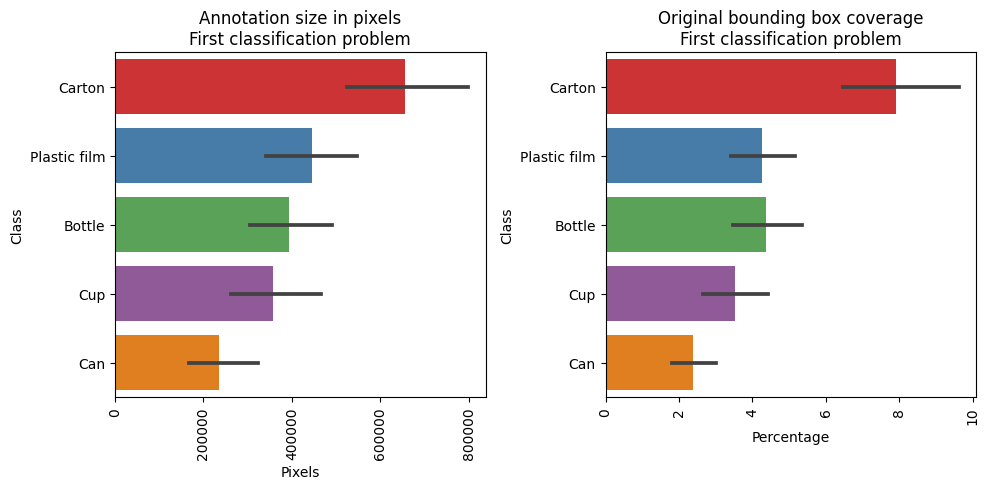

In [46]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True

plt.subplot(1, 2, 1)
sns.barplot(annot_df, y="c1_label", x="bbox_area", estimator="mean", palette="Set1", order=["Carton","Plastic film","Bottle","Cup","Can"])
plt.title("Annotation size in pixels\nFirst classification problem")
plt.xlabel("Pixels")
plt.ylabel("Class")
plt.xticks(rotation = 90)

plt.subplot(1, 2, 2)
sns.barplot(annot_df, y="c1_label", x="bbox_pct", estimator="mean", palette="Set1", order=["Carton","Plastic film","Bottle","Cup","Can"])
plt.title("Original bounding box coverage\nFirst classification problem")
plt.xlabel("Percentage")
plt.ylabel("Class")
plt.xticks(rotation = 90)

plt.show()

plt.rcParams.update(plt.rcParamsDefault)

Annotations of plastic bottles tend to be larger than those of glass bottles, and annotations of plastic bottles also tend to occupy a larger percentage of the original picture. We notice, however, that on average bottles (whether made of glass or plastic) tend to occupy less than 5% of the total image.

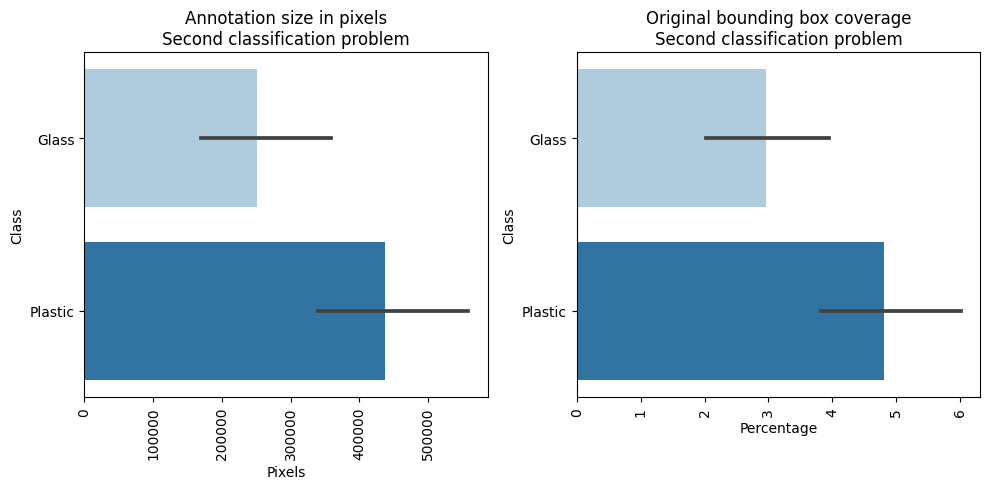

In [ ]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True

plt.subplot(1, 2, 1)
sns.barplot(annot_df, y="c2_label", x="bbox_area", estimator="mean", palette="Paired")
plt.title("Annotation size in pixels\nSecond classification problem")
plt.xlabel("Pixels")
plt.ylabel("Class")
plt.xticks(rotation = 90)

plt.subplot(1, 2, 2)
sns.barplot(annot_df, y="c2_label", x="bbox_pct", estimator="mean", palette="Paired")
plt.title("Original bounding box coverage\nSecond classification problem")
plt.xlabel("Percentage")
plt.ylabel("Class")
plt.xticks(rotation = 90)

plt.show()

plt.rcParams.update(plt.rcParamsDefault)

### Image backgrounds

Next, we would like to merge in information about the type of background to the annotations dataset. However, this will need some additional pre-processing because each image can contain multiple background annotation (e.g. if the object is set against a background of both vegetation and pavement).



Some background annotations appear in duplicate. For example, a single image is sometimes tagged with the label "Vegetation" twice or more.

The label for one type of annotation is missing, which means we can't identify what type of background it refers to. In the scene_annotations file, background are labelled from 0 to 7 (8 categories) but in the labels dictionary, we only have labels for categories 0 to 6 (7 categories).

In [ ]:
scene_annotations_df = pd.json_normalize(annotdata["scene_annotations"], record_path =['background_ids'], meta=['image_id'])
scene_annotations_df.rename(columns={0: "scene_category_id"}, inplace=True)
scene_annotations_df.drop_duplicates(keep='first',inplace=True)

In [ ]:
scene_annotations_df.head(3)

,scene_category_id,image_id
0,1,0
1,1,1
2,2,2


In [ ]:
scene_annotations_df.scene_category_id.unique()

array([1, 2, 5, 7, 3, 0, 4, 6])

We also need to merge in the labels for each background annotation (so we can have both the number and the label, e.g. scene_category_id=6 and scene_category="Water").

In [ ]:
scene_categories_df = pd.DataFrame(annotdata["scene_categories"]).rename(columns={"id":"scene_category_id", "name":"scene_category"})

In [ ]:
scene_categories_df.scene_category_id.unique()

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
scene_annotations_df = pd.merge(scene_annotations_df,scene_categories_df,left_on="scene_category_id",right_on="scene_category_id",how="left")

In [ ]:
scene_annotations_df = scene_annotations_df[["image_id","scene_category"]]
scene_annotations_df.reset_index(inplace=True, drop=True)

In [ ]:
scene_annotations_df = scene_annotations_df[~pd.isna(scene_annotations_df.scene_category)]

Finally, we aggregate all background annotations at the image level, with one row per image and no duplicate rows. If an image was tagged with both "Indoor" and "Vegetation", its new label will be "Indoor & Vegetation". In this step, we have created multiple new levels of the background annotation variable - some with very low counts, where unusual combinations have resulted in new levels (e.g. "Vegetation & Pavement & Sand, Dirt, Pebbles & Water").

In [ ]:
image_backgrounds_df = pd.DataFrame(scene_annotations_df.groupby(['image_id'])['scene_category'].agg(' & '.join))

In [ ]:
annot_df = annot_df.merge(image_backgrounds_df,how="left",on="image_id")

In [ ]:
annot_df.head(3)

,id,image_id,category_id,segmentation,bbox,iscrowd,category,supercategory,c1_label,c1_numlabel,c2_label,c2_numlabel,bbox_area,image_area,bbox_pct,scene_category
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...","[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle,Bottle,Bottle,2.0,Glass,2.0,590934.0,3149313,18.763902,"Indoor, Man-made"
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...","[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton,Carton,Carton,3.0,NaN,NaN,2170651.0,3149313,68.924588,"Indoor, Man-made"
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...","[531.0, 292.0, 1006.0, 672.0]",0,Other carton,Carton,Carton,3.0,NaN,NaN,676032.0,3149313,21.466015,"Indoor, Man-made"


We consolidate rare categories (fewer than 3% of all images) into a single category called "Other background".

In [ ]:
scenes_to_consolidate = annot_df["scene_category"].value_counts(normalize=True).index[annot_df["scene_category"].value_counts(normalize=True)<0.03]
annot_df.loc[annot_df["scene_category"].isin(scenes_to_consolidate),"scene_category"] = "Other background"

In [ ]:
#Descriptive statistics for categories in first classification problem
background_by_c1 = pd.DataFrame(annot_df.groupby(["c1_label","scene_category"]).size(),columns=["count"])
background_by_c1["total"] = background_by_c1.groupby('c1_label')["count"].transform('sum')
background_by_c1["pct_background"] = background_by_c1["count"]/background_by_c1["total"]*100

#Descriptive statistics for categories in second classification problem
background_by_c2 = pd.DataFrame(annot_df.groupby(["c2_label","scene_category"]).size(),columns=["count"])
background_by_c2["total"] = background_by_c2.groupby('c2_label')["count"].transform('sum')
background_by_c2["pct_background"] = background_by_c2["count"]/background_by_c2["total"]*100

Finally, we visualize the distribution of image backgrounds by our classes for both classification problems. The purpose of this visualization is to get a sense of whether some objects are more likely to appear against certain background scenes.

We can see that, compared to other objects, cans are more likely to appear in a background of only vegetation (25% of cans). Other than this, there are no notable differences in background scenes between the five classes.

In [ ]:
background_by_c1["pct_background"].unstack(level=1)

scene_category,"Indoor, Man-made",Other background,Pavement,"Pavement & Sand, Dirt, Pebbles & Water & Vegetation","Sand, Dirt, Pebbles",Vegetation,Vegetation & Pavement,"Vegetation & Pavement & Sand, Dirt, Pebbles","Vegetation & Pavement & Sand, Dirt, Pebbles & Water","Vegetation & Sand, Dirt, Pebbles","Vegetation & Sand, Dirt, Pebbles & Pavement"
c1_label,,,,,,,,,,,
Bottle,8.705882,34.588235,8.941176,3.529412,4.470588,16.235294,4.470588,5.647059,3.764706,6.352941,3.294118
Can,9.090909,32.727273,9.090909,2.727273,2.727273,24.545455,8.636364,2.272727,1.363636,5.909091,0.909091
Carton,9.426230,44.262295,13.114754,2.459016,2.459016,8.606557,5.737705,4.508197,2.459016,3.688525,3.278689
Cup,7.368421,41.578947,12.631579,3.684211,4.736842,11.052632,3.157895,2.105263,1.578947,8.421053,3.684211
Plastic film,2.017937,40.807175,5.605381,3.363229,7.847534,9.417040,5.156951,6.053812,3.587444,11.883408,4.260090


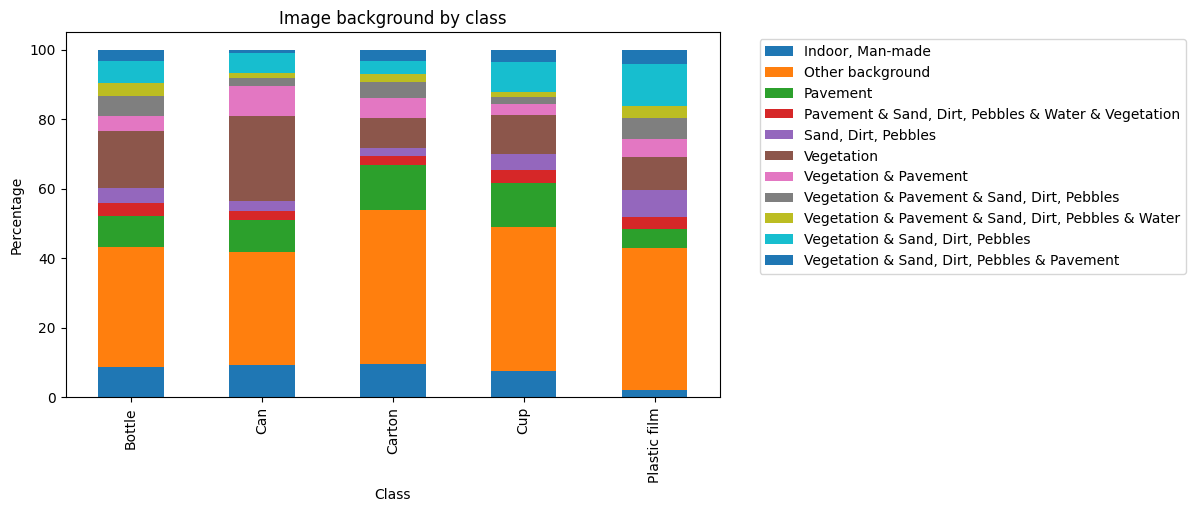

In [ ]:
background_by_c1["pct_background"].unstack(level=1).plot(kind="bar",stacked=True,figsize=(12,5))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.title("Percentage against each scene background\nFirst classification problem")
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.title("Image background by class")
plt.show()

Compared to plastic bottles, glass bottles are more likely to appear against a background of "Sand/dirt/pebbles" (13% vs. 2%). On the other hand, plastic bottles are slightly more likely to appear against a backdrop of Vegetation only (17% vs. 14%).

In [ ]:
background_by_c2["pct_background"].unstack(level=1)

scene_category,"Indoor, Man-made",Other background,Pavement,"Pavement & Sand, Dirt, Pebbles & Water & Vegetation","Sand, Dirt, Pebbles",Vegetation,Vegetation & Pavement,"Vegetation & Pavement & Sand, Dirt, Pebbles","Vegetation & Pavement & Sand, Dirt, Pebbles & Water","Vegetation & Sand, Dirt, Pebbles","Vegetation & Sand, Dirt, Pebbles & Pavement"
c2_label,,,,,,,,,,,
Glass,8.910891,34.653465,8.910891,1.980198,12.871287,13.861386,2.970297,5.940594,2.970297,3.960396,2.970297
Plastic,8.641975,34.567901,8.950617,4.012346,1.851852,16.975309,4.938272,5.555556,4.012346,7.098765,3.395062


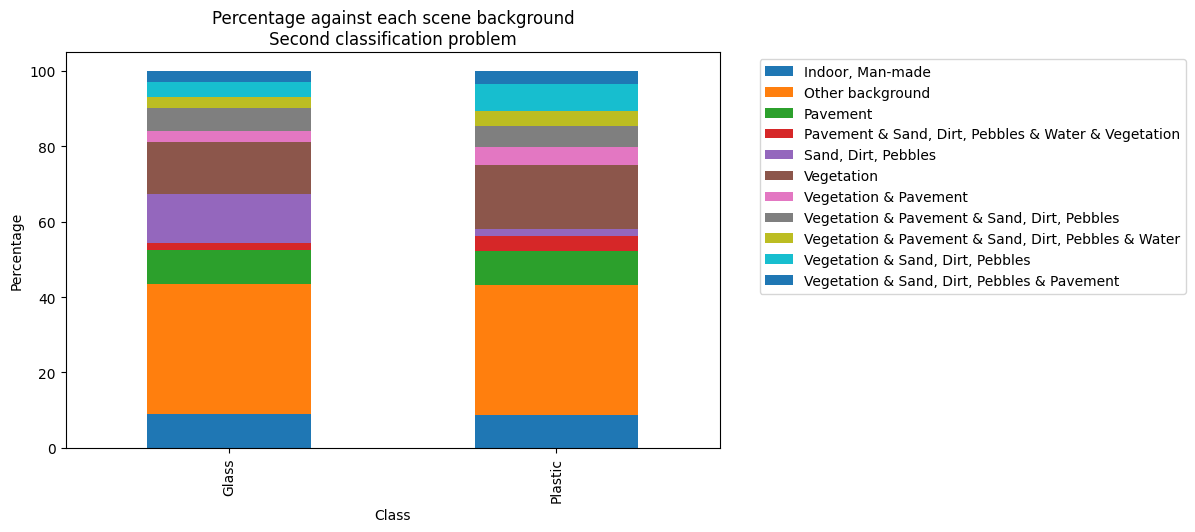

In [ ]:
background_by_c2["pct_background"].unstack(level=1).plot(kind="bar",stacked=True,figsize=(12,5))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.title("Percentage against each scene background\nSecond classification problem")
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.show()

## 4) Save data

Having merged the information on images properties (e.g. size and bounding box coverage), background annotations and class labels to our annotations dataframe, we can save this DataFrame to a '.csv' file locally.

In [ ]:
annot_df.head()

,id,image_id,category_id,segmentation,bbox,iscrowd,category,supercategory,c1_label,c1_numlabel,c2_label,c2_numlabel,bbox_area,image_area,bbox_pct,scene_category
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...","[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle,Bottle,Bottle,2.0,Glass,2.0,590934.0,3149313,18.763902,"Indoor, Man-made"
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...","[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton,Carton,Carton,3.0,NaN,NaN,2170651.0,3149313,68.924588,"Indoor, Man-made"
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...","[531.0, 292.0, 1006.0, 672.0]",0,Other carton,Carton,Carton,3.0,NaN,NaN,676032.0,3149313,21.466015,"Indoor, Man-made"
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...","[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle,Bottle,Bottle,2.0,Plastic,1.0,187000.0,3149313,5.937803,Pavement
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...","[632.0, 989.0, 44.0, 51.0]",0,Plastic bottle cap,Bottle cap,NaN,NaN,NaN,NaN,2244.0,3149313,0.071254,Pavement


In [ ]:
annot_df.to_csv("{}/{}".format(features_path,"clean-annotations-data.csv"))